<a href="https://colab.research.google.com/github/samanemami/TFBoostedTree/blob/main/memory_consumption_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import tracemalloc
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Import dataset

In [ ]:
df = pd.read_csv('../input/heart-disease-uci/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Preparing the inputs of the model

In [ ]:
X = df.drop('target',axis = 1)
y = df['target']

In [ ]:
feature = []
for i in range(len(X.columns)):
    feature.append(str(i))

col_rename = {i: j for i, j in zip(X.columns, feature)}
X = X.rename(columns=col_rename, inplace=False)
X = X.astype("int64")
y = y.astype("int64")

In [ ]:
def _make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        NUM_EXAMPLES = len(y)
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # For training, cycle thru dataset as many times as need (n_epochs=None).
        dataset = dataset.repeat(n_epochs)
        # In memory training doesn't use batching.
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

In [ ]:
train_input_fn = _make_input_fn(X, y)

num_columns = feature
feature_columns = []
n_classes = len(np.unique(y))

for feature_name in num_columns:
    feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                                            dtype=tf.float32))

# Define the model

In [ ]:
T = 100
step = 1
t = range(1, T + 1, step)
mem = np.zeros((T,))
for i, tree in enumerate(t):
    tracemalloc.start()
    tracemalloc.clear_traces()
    zero_size = tracemalloc.get_traced_memory()[0]

    est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                              n_batches_per_layer=1,
                                              n_classes=n_classes,
                                              n_trees=tree,
                                              max_depth=5,
                                              learning_rate=0.1,
                                              label_vocabulary=None,
                                              center_bias=False
                                              )
    est.train(train_input_fn, max_steps=None,
              steps=100)
    mem[i] = tracemalloc.get_traced_memory()[0] - zero_size
    clear_output()

# Memory usage

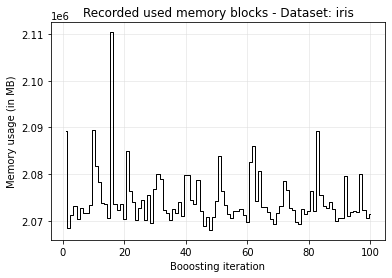

In [ ]:
fig, ax1 = plt.subplots()
ax1.set_xlabel("Booosting iteration")
ax1.set_ylabel("Memory usage (in MB)")
ln1 = ax1.plot(range(1, T + 1), mem, color='black',
               linewidth=1, drawstyle="steps-mid")
plt.title("Recorded used memory blocks - Dataset: iris")
plt.grid(True, linewidth=1, color='gainsboro', alpha=0.5)